# **Data 200 - Final Project**


Author:  Aryan Jain, Micah Billington, Rupesh Rangwani, Devesh Talreja

Date : 8th April, 2024

## **Summary Of Contents**

### This Final Project contains the following sections :
1. Introduction
2. Data Retrieval & Cleaning
3. Data Preprocessing
4. Exploratory Data Analysis (EDA)
5. Model Application
6. Inference & Prediction
7. Conclusion

# 1. Introduction
<img src="Stack_Overflow.png" width="400" align="centre">

- The full notebook and datasets can be found on GitHub: https://github.com/TrueCodee/Final-Project

# 2. Data Retrieval & Data Cleaning

### 2.1 Importing Libraries

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

### 2.2    Data Retrieval & Data Cleaning

In [17]:
# Import Data
df = pd.read_csv('survey_results_public.csv')

# Convert 'YearsCode' and 'YearsCodePro' to numeric, handling special cases
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce', downcast='integer')
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce', downcast='integer')

# Categorize 'YearsCodePro' into experience levels
def categorize_experience(years):
    if pd.isna(years):
        return 'Unknown'
    elif years <= 2:
        return 'Novice'
    elif years <= 5:
        return 'Intermediate'
    elif years <= 10:
        return 'Experienced'
    else:
        return 'Veteran'

df['ExperienceLevel'] = df['YearsCodePro'].apply(categorize_experience)

# Create binary indicators for programming languages of interest
languages_of_interest = ['Python', 'JavaScript', 'R', 'HTML/CSS', 'SQL', 'Java', 'C#', 'TypeScript', 'C', 'C++']
for language in languages_of_interest:
    # Escape special characters for regular expressions
    language_escaped = re.escape(language)
    df[language] = df['LanguageHaveWorkedWith'].str.contains(r'(?i)\b' + language_escaped + r'\b', na=False)


## 3. Data Processing

Age Group Analysis: Calculate Language Usage by Age Group

In [18]:
# Calculate the percentage of respondents in each age group who use Python and SQL
languages_of_interest_ds = ['Python','R','SQL']  # Adjusted list for data science relevant languages

age_language_usage = df.groupby('Age')[languages_of_interest_ds].mean().reset_index()

# Preparing the data for visualization (long format)
age_language_usage_long = pd.melt(age_language_usage, id_vars=['Age'], value_vars=languages_of_interest_ds, 
                                  var_name='Language', value_name='Usage')

Visualize Language Usage by Age Group

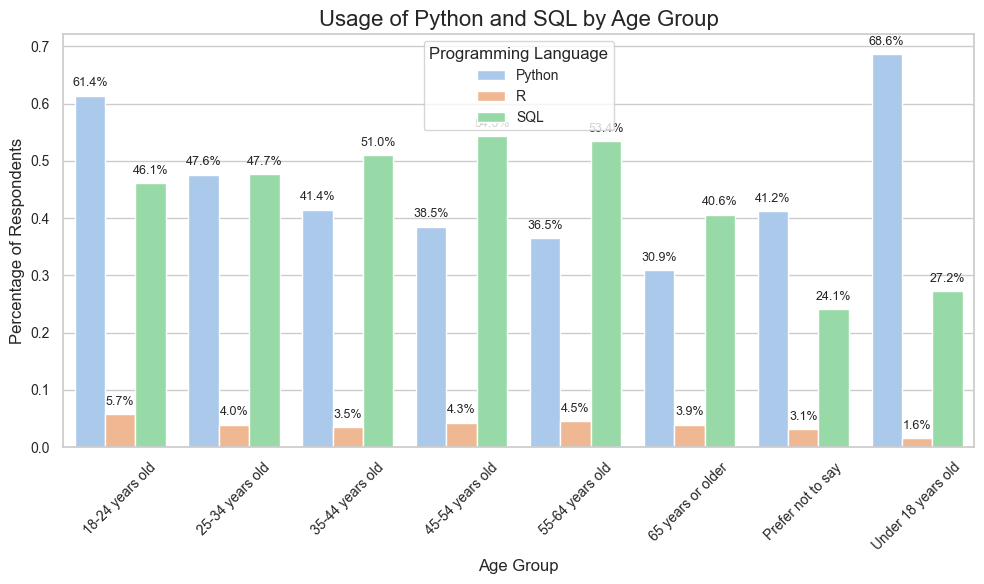

In [19]:
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Create the barplot
chart = sns.barplot(
    x='Age', 
    y='Usage', 
    hue='Language', 
    data=age_language_usage_long,
    errorbar=None
)

# Customize the visual elements
chart.set_title('Usage of Python and SQL by Age Group', fontsize=16)
chart.set_ylabel('Percentage of Respondents', fontsize=12)
chart.set_xlabel('Age Group', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Programming Language', fontsize=10)

# Adding data labels on top of the bars
for p in chart.patches:
    # Get the height of the bar
    height = p.get_height()
    # If height is 0, we don't want to display the label
    if height > 0:
        chart.annotate(f'{height:.1%}', 
                       (p.get_x() + p.get_width() / 2., height), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points', fontsize=9)

plt.tight_layout()
plt.show()

## 5. Model Appication

### 5.1 Logistic Regression

In [20]:
# Filter for users who have worked with Python, R, or SQL
df_langs = df[df['LanguageHaveWorkedWith'].str.contains('Python|R|SQL', regex=True, na=False)].copy()

# Create binary flags for Python, R, and SQL
df_langs['PyRSQL'] = df_langs['LanguageHaveWorkedWith'].str.contains('.*Python.*R.*SQL.*', regex=True).astype(int)

# Convert 'Age' to string to ensure that the dummy variables are handled correctly
df_langs['Age'] = df_langs['Age'].astype(str)

# Create dummy variables for the 'Age' groups
age_dummies = pd.get_dummies(df_langs['Age'], drop_first=True)

# Perform logistic regression for Python usage
y_PyRSQL = df_langs['PyRSQL']  # Response variable
X_PyRSQL = age_dummies.astype(float) # Independent variables converted to float
X_PyRSQL = sm.add_constant(X_PyRSQL) # Add a constant to the model (the intercept)
model_PyRSQL = sm.Logit(y_PyRSQL, X_PyRSQL).fit()
print(model_PyRSQL.summary())


# Set up the response variable for combined Python, R, and SQL usage
df_langs['PyRSQL'] = df_langs['LanguageHaveWorkedWith'].str.contains('.*Python.*R.*SQL.*', regex=True).astype(int)
y_combined = df_langs['PyRSQL']

# Split the dataset for the combined usage
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_python, y_combined, test_size=0.2, random_state=42
)
# Logistic Regression Model for combined usage
log_reg_model_combined = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
log_reg_model_combined.fit(X_train_combined, y_train_combined)

Optimization terminated successfully.
         Current function value: 0.323509
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 PyRSQL   No. Observations:                67002
Model:                          Logit   Df Residuals:                    66994
Method:                           MLE   Df Model:                            7
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                0.007621
Time:                        15:30:19   Log-Likelihood:                -21676.
converged:                       True   LL-Null:                       -21842.
Covariance Type:            nonrobust   LLR p-value:                 5.577e-68
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.8314      0.024    -75.371      0.000      -1.879      -1.784
25-34

LogisticRegression(solver='liblinear')

## 6. Inference & Prediction

In [21]:
# Make predictions for combined usage
y_pred_log_reg_combined = log_reg_model_combined.predict(X_test_combined)
y_pred_proba_log_reg_combined = log_reg_model_combined.predict_proba(X_test_combined)[:, 1]

# Evaluation for combined usage
roc_auc_log_reg_combined = roc_auc_score(y_test_combined, y_pred_proba_log_reg_combined)
accuracy_log_reg_combined = accuracy_score(y_test_combined, y_pred_log_reg_combined)
report_log_reg_combined = classification_report(y_test_combined, y_pred_log_reg_combined, zero_division=0)

print("Logistic Regression - Combined Python, R, and SQL usage")
print("AUC-ROC:", roc_auc_log_reg_combined)
print("Accuracy:", accuracy_log_reg_combined)
print(report_log_reg_combined)

Logistic Regression - Combined Python, R, and SQL usage
AUC-ROC: 0.5624969079630706
Accuracy: 0.9013506454742184
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     12079
           1       0.00      0.00      0.00      1322

    accuracy                           0.90     13401
   macro avg       0.45      0.50      0.47     13401
weighted avg       0.81      0.90      0.85     13401

